## Modeling Phase 1 - Autoregression baselines

### Imports + setup

In [9]:
from pathlib import Path
import sys

repo_root = Path.cwd() if (Path.cwd() / 'code').exists() else Path.cwd().parents[0]
sys.path.insert(0, str(repo_root))
sys.path.insert(0, str(repo_root / "code"))

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from utils.datasets import FUSForecastWindowDataset
from utils.modeling_functions import (
    iter_windows,
    sample_train_frames_for_pca,
    compute_frame_metrics,
    evaluate_model_on_dataset,
    residual_acf_latent,
    ljung_box_test,
    predict_persistence,
    fit_pixel_ar,
    predict_pixel_ar,
    fit_pca_var,
    predict_pca_var,    fit_pca_ar_diag,    predict_pca_ar_diag,
    plot_triplet,
)

# Backward-compatible aliases
predict_pca_ar = predict_pca_ar_diag
fit_pca_ar = fit_pca_ar_diag



In [10]:
manifest_path = 'C:\\Users\\ESPCI\\Documents\\GitHub\\fUSPredict\\derivatives\\preprocessing\\splits_single_secundo.json'

output_dir = str(repo_root / 'derivatives' / 'modeling' / 'phase1_baselines')
os.makedirs(output_dir, exist_ok=True)

W = 8
K = 1
S = 1
seed = 42
ridge_lambda = 1e-2
max_pca_frames = 4000

p_list = [1, 2, 5]
d_list = [256, 512, 1024]
assert W >= max(p_list), 'window_size W must be >= max(p_list)'
use_gpu = True
gpu_device = 'cuda'


#### Load datasets

In [11]:
train_ds = FUSForecastWindowDataset(
    manifest_path=manifest_path, split='train', window_size=W, pred_horizon=K, stride=S
)
test_ds = FUSForecastWindowDataset(
    manifest_path=manifest_path, split='test', window_size=W, pred_horizon=K, stride=S
)
print('Train windows:', len(train_ds))
print('Test windows:', len(test_ds))

Train windows: 11544
Test windows: 2241


---
### Run models


In [12]:
metrics_rows = []
metrics_rows_std = []

# Persistence on cpu will take 0.5 seconds
persistence_metrics = evaluate_model_on_dataset(
    lambda ctx: predict_persistence(ctx, K=K), test_ds
)
persistence_metrics_std = evaluate_model_on_dataset(
    lambda ctx: predict_persistence(ctx, K=K), test_ds, standardize=True
)
metrics_rows.append({'model': 'persistence', **persistence_metrics})
metrics_rows_std.append({'model': 'persistence', **persistence_metrics_std})


In [ ]:
# Pixel AR on cpu will take about 20 seconds
pixel_ar_params = {}
for p in p_list:
    params = fit_pixel_ar(train_ds, p=p, ridge_lambda=ridge_lambda)
    pixel_ar_params[p] = params
    pred_fn = lambda ctx, _p=p: predict_pixel_ar(ctx, pixel_ar_params[_p], K=K)
    metrics = evaluate_model_on_dataset(pred_fn, test_ds)
    metrics_std = evaluate_model_on_dataset(pred_fn, test_ds, standardize=True)
    metrics_rows.append({'model': f'pixel_ar_p{p}', **metrics})
    metrics_rows_std.append({'model': f'pixel_ar_p{p}', **metrics_std})
    out_path = os.path.join(output_dir, f'pixel_ar_p{p}.npz')
    
    np.savez_compressed(out_path, A=params['A'], b=params['b'], p=params['p'])


In [ ]:
# PCA + VAR on gpu will take about 1 min
pca_var_params = {}
for d in d_list:
    for p in p_list:
        params = fit_pca_var(
            train_ds, d=d, p=p, ridge_lambda=ridge_lambda,
            max_pca_frames=max_pca_frames, seed=seed, use_torch=True, device=gpu_device
        )
        pca_var_params[(d, p)] = params
        pred_fn = lambda ctx, _d=d, _p=p: predict_pca_var(ctx, pca_var_params[(_d, _p)], K=K)
        metrics = evaluate_model_on_dataset(pred_fn, test_ds)
        metrics_std = evaluate_model_on_dataset(pred_fn, test_ds, standardize=True)
        metrics_rows.append({'model': f'pca_var_d{d}_p{p}', **metrics})
        metrics_rows_std.append({'model': f'pca_var_d{d}_p{p}', **metrics_std})
        out_path = os.path.join(output_dir, f'pca_var_d{d}_p{p}.npz')
        
        np.savez_compressed(
            out_path,
            mean=params['mean'],
            components=params['components'],
            var_weights=params['var_weights'],
            p=params['p'],
            d=params['d'],
        )


In [ ]:
# PCA + AR (per-component)
pca_ar_params = {}
for d in d_list:
    for p in p_list:
        params = fit_pca_ar_diag(
            train_ds, d=d, p=p, ridge_lambda=ridge_lambda,
            max_pca_frames=max_pca_frames, seed=seed
        )
        pca_ar_params[(d, p)] = params
        pred_fn = lambda ctx, _d=d, _p=p: predict_pca_ar_diag(ctx, pca_ar_params[(_d, _p)], K=K)
        metrics = evaluate_model_on_dataset(pred_fn, test_ds)
        metrics_std = evaluate_model_on_dataset(pred_fn, test_ds, standardize=True)
        metrics_rows.append({'model': f'pca_ar_d{d}_p{p}', **metrics})
        metrics_rows_std.append({'model': f'pca_ar_d{d}_p{p}', **metrics_std})
        out_path = os.path.join(output_dir, f'pca_ar_d{d}_p{p}.npz')
        
        np.savez_compressed(
            out_path,
            mean=params['mean'],
            components=params['components'],
            ar_weights=params['ar_weights'],
            p=params['p'],
            d=params['d'],
        )


---
### Save metrics & stuff 

In [16]:
metrics_df = pd.DataFrame(metrics_rows)
metrics_df = metrics_df.sort_values('MSE_mean').reset_index(drop=True).round(3)
metrics_path = os.path.join(output_dir, 'metrics.csv')
metrics_df.to_csv(metrics_path, index=False)

metrics_df_std = pd.DataFrame(metrics_rows_std)
metrics_df_std = metrics_df_std.sort_values('MSE_mean').reset_index(drop=True).round(3)
metrics_std_path = os.path.join(output_dir, 'metrics_standardized.csv')
metrics_df_std.to_csv(metrics_std_path, index=False)

display(metrics_df)
display(metrics_df_std)


,model,MSE_mean,MSE_std,RMSE_mean,RMSE_std,MAE_mean,MAE_std,R2_mean,R2_std,n_windows
0,pixel_ar_p5,3411.080,3397.812,50.928,28.590,17.236,11.091,0.978,0.005,2241
1,pixel_ar_p2,4101.257,4090.458,55.818,31.395,18.923,12.165,0.973,0.005,2241
2,pixel_ar_p1,5385.707,5379.300,63.943,36.013,21.753,13.952,0.965,0.007,2241
3,persistence,5389.947,5356.120,64.033,35.912,21.528,13.929,0.965,0.007,2241
4,pca_ar_d1024_p5,79188.691,84215.326,237.057,151.633,92.654,67.246,0.573,0.068,2241
5,pca_ar_d512_p5,85123.626,90274.430,246.066,156.765,96.098,69.644,0.538,0.072,2241
6,pca_ar_d1024_p2,88445.085,94292.179,250.942,159.603,97.684,71.269,0.518,0.076,2241
7,pca_ar_d256_p5,91422.457,97215.941,255.375,161.883,99.890,72.421,0.500,0.077,2241
8,pca_ar_d512_p2,91923.456,97957.195,255.910,162.584,99.606,72.674,0.498,0.079,2241
9,pca_ar_d1024_p1,94984.604,101791.435,260.112,165.307,101.153,74.095,0.481,0.083,2241


,model,MSE_mean,MSE_std,RMSE_mean,RMSE_std,MAE_mean,MAE_std,R2_mean,R2_std,n_windows
0,pixel_ar_p5,0.022,0.005,0.148,0.015,0.047,0.003,0.978,0.005,2241
1,pixel_ar_p2,0.027,0.005,0.162,0.015,0.052,0.003,0.973,0.005,2241
2,pixel_ar_p1,0.035,0.007,0.186,0.017,0.060,0.004,0.965,0.007,2241
3,persistence,0.035,0.007,0.186,0.018,0.059,0.004,0.965,0.007,2241
4,pca_ar_d1024_p5,0.427,0.068,0.651,0.055,0.242,0.043,0.573,0.068,2241
5,pca_ar_d512_p5,0.462,0.072,0.677,0.055,0.251,0.044,0.538,0.072,2241
6,pca_ar_d1024_p2,0.482,0.076,0.692,0.057,0.255,0.046,0.518,0.076,2241
7,pca_ar_d256_p5,0.500,0.077,0.705,0.056,0.261,0.045,0.500,0.077,2241
8,pca_ar_d512_p2,0.502,0.079,0.706,0.058,0.260,0.047,0.498,0.079,2241
9,pca_ar_d1024_p1,0.519,0.083,0.718,0.060,0.264,0.049,0.481,0.083,2241


In [17]:
best_row = metrics_df.iloc[0]
best_model = best_row['model']
print('Best model:', best_model)

if best_model.startswith('pca_var'):  # use its PCA for residuals
    parts = best_model.split('_')
    d = int(parts[2][1:])
    p = int(parts[3][1:])
    diag_params = pca_var_params[(d, p)]
    predict_fn = lambda ctx: predict_pca_var(ctx, diag_params, K=K)
else:
    # Fit a PCA model for diagnostics only
    diag_d = 64
    frames_flat = sample_train_frames_for_pca(train_ds, max_pca_frames, seed)
    from sklearn.decomposition import PCA
    pca = PCA(n_components=diag_d, svd_solver='randomized')
    pca.fit(frames_flat)
    diag_params = {
        'mean': pca.mean_.astype(np.float32),
        'components': pca.components_.astype(np.float32),
    }
    if best_model.startswith('pixel_ar'):  # choose the matching p
        p = int(best_model.split('p')[-1])
        predict_fn = lambda ctx: predict_pixel_ar(ctx, pixel_ar_params[p], K=K)
    else:
        predict_fn = lambda ctx: predict_persistence(ctx, K=K)

residual_latents = []
max_items = 200
for context, target in iter_windows(test_ds, max_items=max_items):
    pred = predict_fn(context)
    resid = (target[0] - pred[0])[0]
    mean = diag_params['mean']
    comps = diag_params['components']
    resid_lat = (resid.reshape(1, -1) - mean) @ comps.T
    residual_latents.append(resid_lat[0])
residual_latents = np.stack(residual_latents, axis=0)
acf_summary = residual_acf_latent(residual_latents, max_lag=20)
print('Mean abs ACF by lag:', acf_summary['mean_abs_acf_by_lag'])
lb = ljung_box_test(residual_latents, lags=[10, 20])
if lb is not None:
    print('Ljung-Box p-values (first component):')
    print(lb[0])

Best model: pixel_ar_p5
Mean abs ACF by lag: [1.         0.10614197 0.10181939 0.05879464 0.07719002 0.14735122
 0.07281206 0.0708533  0.06719348 0.06636043 0.0632949  0.05223032
 0.06277153 0.05827862 0.05849436 0.06562082 0.05266724 0.05170234
 0.05477535 0.05202569 0.04973286]
Ljung-Box p-values (first component):
       lb_stat     lb_pvalue
10  103.446302  1.110902e-17
20  115.542859  1.895934e-15


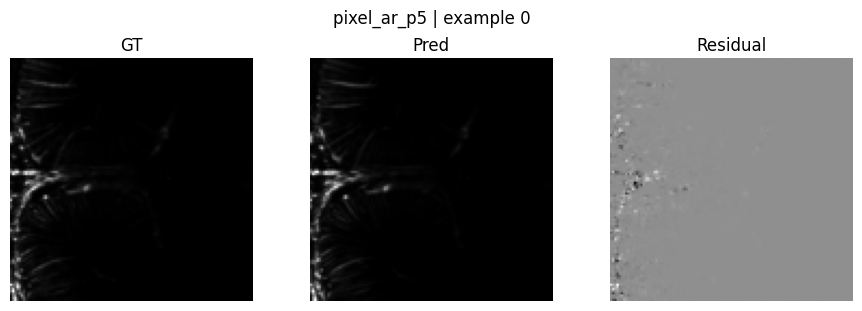

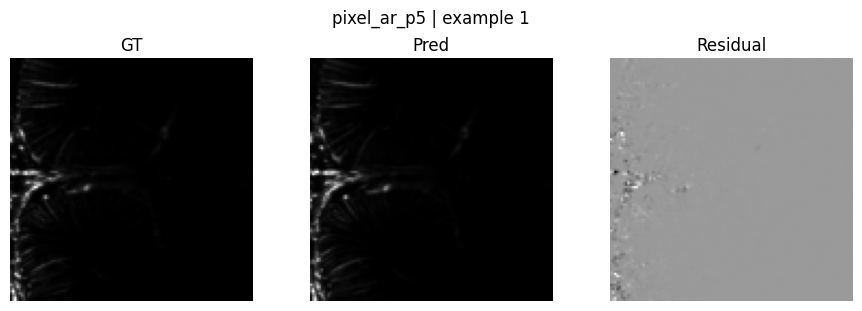

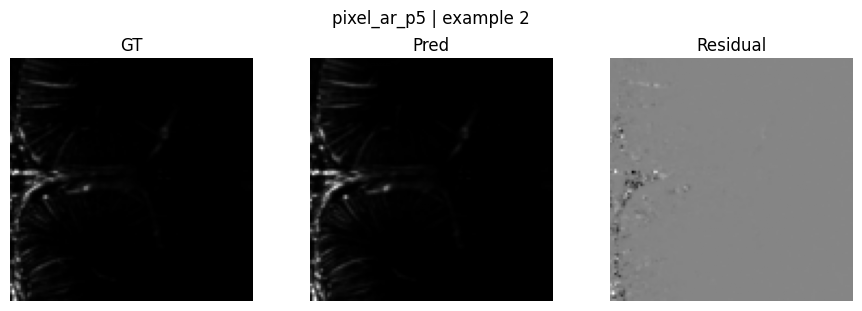

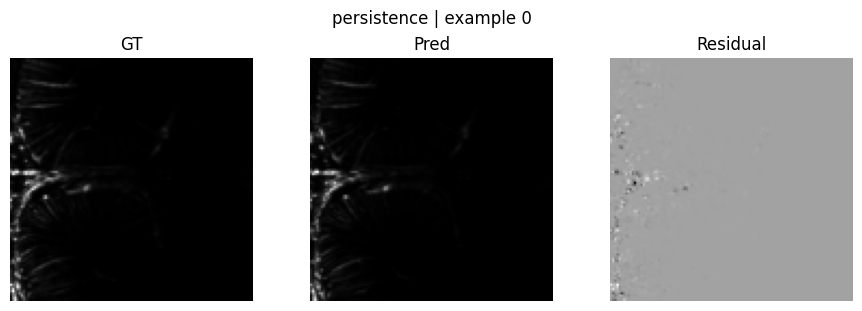

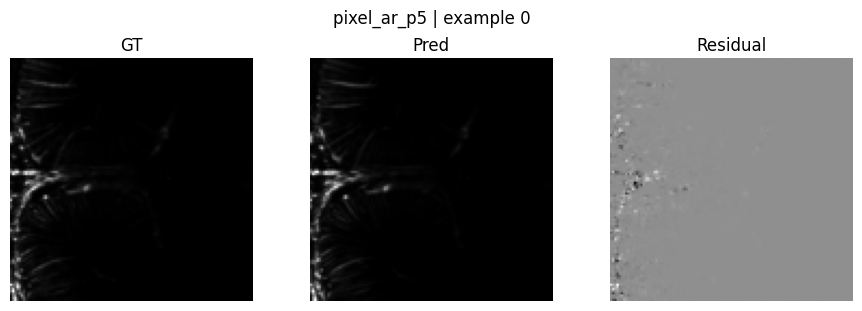

In [18]:
def show_examples(predict_fn, title, n_examples=3):
    for i, (context, target) in enumerate(iter_windows(test_ds, max_items=n_examples)):
        pred = predict_fn(context)
        gt = target[0, 0]
        pr = pred[0, 0]
        resid = gt - pr
        plot_triplet(gt, pr, resid, title=f'{title} | example {i}')


def _build_predictor_registry():
    registry = {}
    registry['persistence'] = (lambda ctx: predict_persistence(ctx, K=1))

    if 'pixel_ar_params' in globals() and isinstance(pixel_ar_params, dict):
        for _p in sorted(pixel_ar_params.keys()):
            registry[f'pixel_ar_p{_p}'] = (lambda ctx, p=_p: predict_pixel_ar(ctx, pixel_ar_params[p], K=1))

    if 'pca_var_params' in globals() and isinstance(pca_var_params, dict):
        for (_d, _p) in sorted(pca_var_params.keys()):
            name = f'pca_var_d{_d}_p{_p}'
            registry[name] = (lambda ctx, d=_d, p=_p: predict_pca_var(ctx, pca_var_params[(d, p)], K=1))

    if 'pca_ar_params' in globals() and isinstance(pca_ar_params, dict):
        for (_d, _p) in sorted(pca_ar_params.keys()):
            name = f'pca_ar_d{_d}_p{_p}'
            registry[name] = (lambda ctx, d=_d, p=_p: predict_pca_ar(ctx, pca_ar_params[(d, p)], K=1))

    return registry


predictors = _build_predictor_registry()

# Show best model examples (safe branch logic)
if 'best_model' in globals() and isinstance(best_model, str):
    if best_model in predictors:
        show_examples(predictors[best_model], best_model)
    else:
        print(f"best_model '{best_model}' not found in predictor registry. Available: {list(predictors.keys())[:5]} ...")
else:
    print("best_model not defined; showing persistence examples.")
    show_examples(predictors['persistence'], 'persistence')

# Optional explicit demos
for demo_name in ['persistence', 'pixel_ar_p5']:
    if demo_name in predictors:
        show_examples(predictors[demo_name], demo_name, n_examples=1)


---
### Exploratory data anlysis

,model,MSE_mean,RMSE_mean,MAE_mean,R2_mean,MSE_std,RMSE_std,MAE_std,R2_std,horizon,n_windows
0,persistence,5335.867,63.678,21.407,0.965,5334.381,35.792,13.897,0.007,1,2127
1,persistence,5436.324,64.248,21.651,0.964,5450.023,36.173,14.023,0.007,2,2127
2,persistence,5649.822,65.547,22.133,0.963,5662.287,36.789,14.331,0.008,5,2127
3,persistence,5858.000,66.794,22.533,0.961,5860.336,37.371,14.548,0.010,10,2127
4,persistence,6077.961,68.006,22.927,0.959,6160.939,38.121,14.892,0.011,20,2127
5,pixel_ar_p5,3378.194,50.649,17.140,0.978,3387.972,28.511,11.071,0.005,1,2127
6,pixel_ar_p5,3517.959,51.680,17.528,0.977,3537.426,29.105,11.300,0.005,2,2127
7,pixel_ar_p5,3819.465,53.863,18.370,0.975,3859.248,30.303,11.754,0.006,5,2127
8,pixel_ar_p5,4090.021,55.659,19.148,0.973,4183.759,31.497,12.096,0.007,10,2127
9,pixel_ar_p5,4734.969,59.654,20.888,0.969,4939.894,34.299,12.918,0.008,20,2127


,model,MSE_mean,RMSE_mean,MAE_mean,R2_mean,MSE_std,RMSE_std,MAE_std,R2_std,horizon,n_windows
0,persistence,0.035,0.186,0.059,0.965,0.007,0.018,0.004,0.007,1,2127
1,persistence,0.036,0.188,0.060,0.964,0.007,0.018,0.004,0.007,2,2127
2,persistence,0.037,0.192,0.061,0.963,0.008,0.021,0.005,0.008,5,2127
3,persistence,0.039,0.196,0.062,0.961,0.010,0.023,0.005,0.010,10,2127
4,persistence,0.041,0.200,0.063,0.959,0.011,0.024,0.006,0.011,20,2127
5,pixel_ar_p5,0.022,0.148,0.047,0.978,0.005,0.015,0.003,0.005,1,2127
6,pixel_ar_p5,0.023,0.151,0.049,0.977,0.005,0.015,0.004,0.005,2,2127
7,pixel_ar_p5,0.025,0.158,0.051,0.975,0.006,0.018,0.004,0.006,5,2127
8,pixel_ar_p5,0.027,0.163,0.054,0.973,0.007,0.020,0.005,0.007,10,2127
9,pixel_ar_p5,0.031,0.174,0.059,0.969,0.008,0.021,0.005,0.008,20,2127


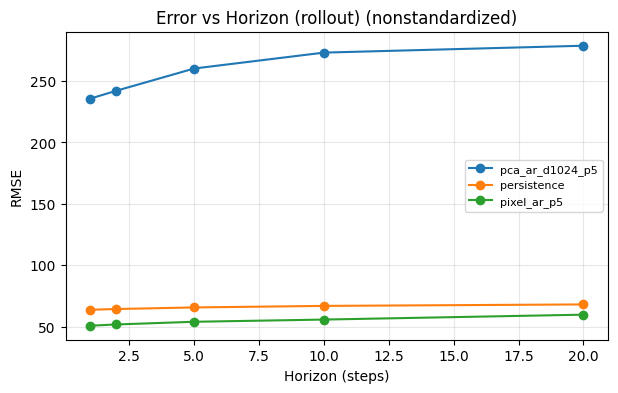

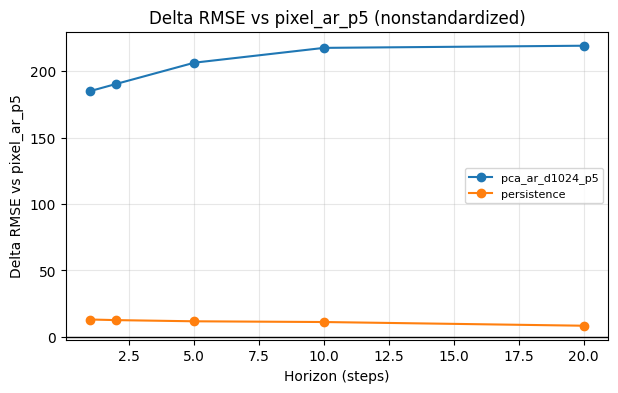

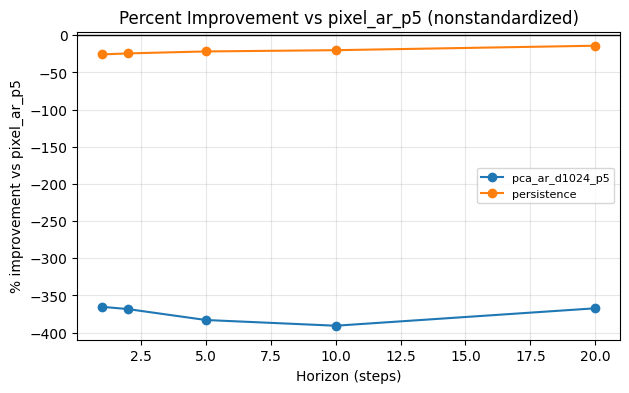

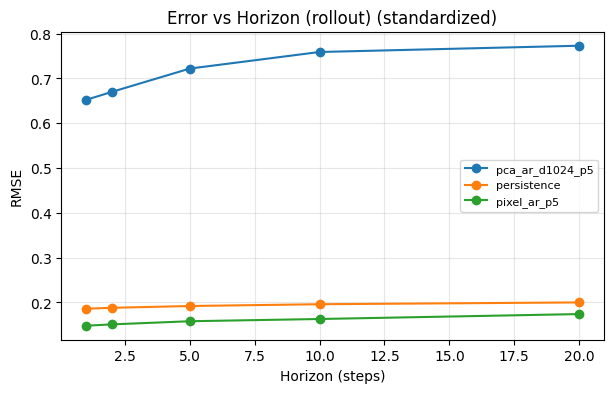

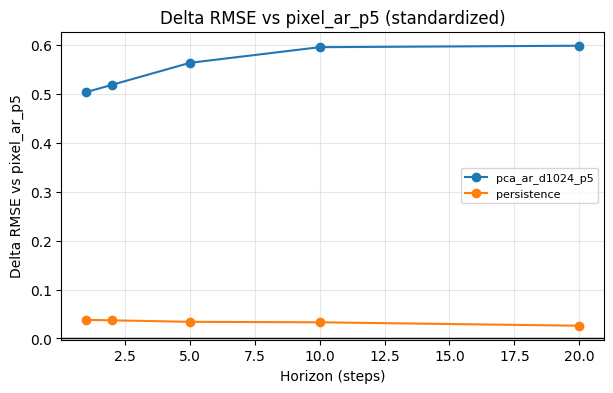

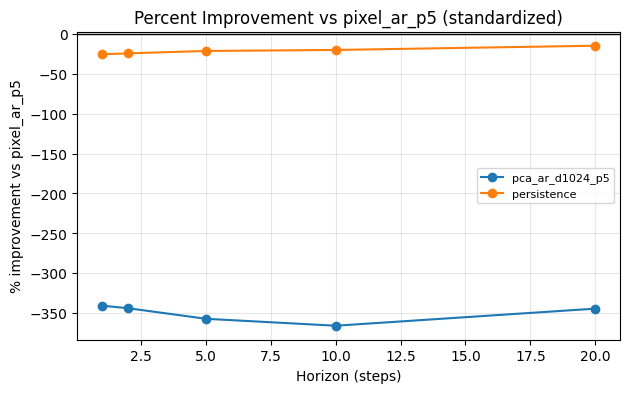

In [30]:
# Decisive diagnostics: horizon rollout (reduced models) --> takes about 6/7min to run
horizons = [1, 2, 5, 10, 20]
max_h = max(horizons)

test_ds_h = FUSForecastWindowDataset(
    manifest_path=manifest_path, split='test', window_size=W, pred_horizon=max_h, stride=S
)

def to_numpy(x):
    if hasattr(x, 'detach'):
        x = x.detach().cpu().numpy()
    return np.asarray(x)

def rollout_predict(predict_step_fn, context, K):
    ctx = to_numpy(context)
    preds = []
    for _ in range(int(K)):
        step = predict_step_fn(ctx)  # [1,1,H,W]
        preds.append(step[0])
        ctx = np.concatenate([ctx[1:], step], axis=0)
    return np.stack(preds, axis=0)  # [K,1,H,W]

def eval_horizons(predict_step_fn, dataset, horizons, max_items=None, standardize=False, decimals=3):
    rows = []
    for h in horizons:
        per_window = []
        for context, target in iter_windows(dataset, max_items=max_items):
            pred = rollout_predict(predict_step_fn, context, h)
            gt = target[h-1, 0]
            pr = pred[h-1, 0]
            per_window.append(compute_frame_metrics(gt, pr, standardize=standardize, decimals=decimals))
        keys = per_window[0].keys()
        agg = {k + '_mean': float(np.round(np.mean([m[k] for m in per_window]), int(decimals))) for k in keys}
        agg.update({k + '_std': float(np.round(np.std([m[k] for m in per_window]), int(decimals))) for k in keys})
        agg['horizon'] = h
        agg['n_windows'] = len(per_window)
        rows.append(agg)
    return rows

# Select models
models = {}
models['persistence'] = lambda ctx: predict_persistence(ctx, K=1)
models['pixel_ar_p5'] = lambda ctx: predict_pixel_ar(ctx, pixel_ar_params[5], K=1)

# Best PCA-AR (optional): pick from metrics_df if present
best_pca_ar = None
if 'metrics_df' in globals():
    for name in metrics_df['model']:
        if str(name).startswith('pca_ar_'):
            best_pca_ar = name
            break
if best_pca_ar is not None:
    parts = best_pca_ar.split('_')
    d = int(parts[2][1:])
    p = int(parts[3][1:])
    models[best_pca_ar] = lambda ctx, _d=d, _p=p: predict_pca_ar_diag(ctx, pca_ar_params[(_d, _p)], K=1)

horizon_rows = []
horizon_rows_std = []
for name, fn in models.items():
    horizon_rows += [dict(model=name, **r) for r in eval_horizons(fn, test_ds_h, horizons, standardize=False)]
    horizon_rows_std += [dict(model=name, **r) for r in eval_horizons(fn, test_ds_h, horizons, standardize=True)]

horizon_df = pd.DataFrame(horizon_rows).round(3)
horizon_df_std = pd.DataFrame(horizon_rows_std).round(3)

display(horizon_df)
display(horizon_df_std)

import matplotlib.pyplot as plt

def plot_horizon_suite(df, suffix=''):
    title_suffix = f' ({suffix})' if suffix else ''

    plt.figure(figsize=(7, 4))
    for model_name, grp in df.groupby('model'):
        plt.plot(grp['horizon'], grp['RMSE_mean'], marker='o', label=model_name)
    plt.xlabel('Horizon (steps)')
    plt.ylabel('RMSE')
    plt.title('Error vs Horizon (rollout)' + title_suffix)
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.show()

    baseline = df[df['model'] == 'pixel_ar_p5'][['horizon', 'RMSE_mean']].rename(columns={'RMSE_mean': 'RMSE_base'})
    if baseline.empty:
        return

    delta_df = df.merge(baseline, on='horizon')
    delta_df['Delta_RMSE'] = delta_df['RMSE_mean'] - delta_df['RMSE_base']
    delta_df['Pct_Improvement'] = (delta_df['RMSE_base'] - delta_df['RMSE_mean']) / delta_df['RMSE_base'] * 100.0

    plt.figure(figsize=(7, 4))
    for model_name, grp in delta_df.groupby('model'):
        if model_name == 'pixel_ar_p5':
            continue
        plt.plot(grp['horizon'], grp['Delta_RMSE'], marker='o', label=model_name)
    plt.axhline(0.0, color='k', linewidth=1)
    plt.xlabel('Horizon (steps)')
    plt.ylabel('Delta RMSE vs pixel_ar_p5')
    plt.title('Delta RMSE vs pixel_ar_p5' + title_suffix)
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.show()

    plt.figure(figsize=(7, 4))
    for model_name, grp in delta_df.groupby('model'):
        if model_name == 'pixel_ar_p5':
            continue
        plt.plot(grp['horizon'], grp['Pct_Improvement'], marker='o', label=model_name)
    plt.axhline(0.0, color='k', linewidth=1)
    plt.xlabel('Horizon (steps)')
    plt.ylabel('% improvement vs pixel_ar_p5')
    plt.title('Percent Improvement vs pixel_ar_p5' + title_suffix)
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.show()

plot_horizon_suite(horizon_df, suffix='nonstandardized')
plot_horizon_suite(horizon_df_std, suffix='standardized')



In [31]:
# Deliverables: tables, plots, summary (saved to output_dir)
import os
import matplotlib.pyplot as plt
from IPython.display import Markdown

output_dir = str(repo_root / 'derivatives' / 'modeling' / 'phase1_baselines')

os.makedirs(output_dir, exist_ok=True)

def export_metrics_table(df, tag):
    cols = ["model", "RMSE_mean", "RMSE_std", "MAE_mean", "MAE_std", "R2_mean", "R2_std", "n_windows"]
    table_df = df[cols].sort_values("RMSE_mean", ascending=True).reset_index(drop=True)
    table_path = os.path.join(output_dir, f"phase1_metrics_table_{tag}.csv")
    table_df.to_csv(table_path, index=False)

    top_df = table_df.head(6)
    top_path = os.path.join(output_dir, f"phase1_metrics_table_top_{tag}.csv")
    top_df.to_csv(top_path, index=False)

    fig, ax = plt.subplots(figsize=(10, 0.4 + 0.35 * len(table_df)))
    ax.axis("off")
    tbl = ax.table(
        cellText=table_df.values,
        colLabels=table_df.columns,
        cellLoc="center",
        loc="center"
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(8)
    tbl.scale(1, 1.2)
    fig.tight_layout()
    fig.savefig(os.path.join(output_dir, f"phase1_metrics_table_{tag}.png"), dpi=300)
    plt.close(fig)

# A) Tables
if "metrics_df" in globals():
    export_metrics_table(metrics_df, "nonstandardized")
    # Backward-compatible filenames (nonstandardized)
    cols = ["model", "RMSE_mean", "RMSE_std", "MAE_mean", "MAE_std", "R2_mean", "R2_std", "n_windows"]
    table_df = metrics_df[cols].sort_values("RMSE_mean", ascending=True).reset_index(drop=True)
    table_df.to_csv(os.path.join(output_dir, "phase1_metrics_table.csv"), index=False)
    table_df.head(6).to_csv(os.path.join(output_dir, "phase1_metrics_table_top.csv"), index=False)

    fig, ax = plt.subplots(figsize=(10, 0.4 + 0.35 * len(table_df)))
    ax.axis("off")
    tbl = ax.table(cellText=table_df.values, colLabels=table_df.columns, cellLoc="center", loc="center")
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(8)
    tbl.scale(1, 1.2)
    fig.tight_layout()
    fig.savefig(os.path.join(output_dir, "phase1_metrics_table.png"), dpi=300)
    plt.close(fig)
else:
    print("metrics_df not found; skipping nonstandardized table export.")

if "metrics_df_std" in globals():
    export_metrics_table(metrics_df_std, "standardized")
else:
    print("metrics_df_std not found; skipping standardized table export.")

def export_horizon_plots(df, tag):
    fig, ax = plt.subplots(figsize=(7, 4))
    for model_name, grp in df.groupby("model"):
        ax.plot(grp["horizon"], grp["RMSE_mean"], marker="o", label=model_name)
    ax.set_title(f"Error vs Horizon (rollout, {tag})")
    ax.set_xlabel("Horizon (steps)")
    ax.set_ylabel("RMSE")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    fig.tight_layout()
    fig.savefig(os.path.join(output_dir, f"error_vs_horizon_{tag}.png"), dpi=300)
    fig.savefig(os.path.join(output_dir, f"error_vs_horizon_{tag}.pdf"))
    if tag == "nonstandardized":
        fig.savefig(os.path.join(output_dir, "error_vs_horizon.png"), dpi=300)
        fig.savefig(os.path.join(output_dir, "error_vs_horizon.pdf"))
    plt.close(fig)

    baseline = df[df["model"] == "pixel_ar_p5"][["horizon", "RMSE_mean"]].rename(columns={"RMSE_mean": "RMSE_base"})
    if baseline.empty:
        print(f"pixel_ar_p5 baseline not found; skipping delta plots for {tag}.")
        return

    delta_df = df.merge(baseline, on="horizon")
    delta_df["Delta_RMSE"] = delta_df["RMSE_mean"] - delta_df["RMSE_base"]

    fig, ax = plt.subplots(figsize=(7, 4))
    for model_name, grp in delta_df.groupby("model"):
        if model_name == "pixel_ar_p5":
            continue
        ax.plot(grp["horizon"], grp["Delta_RMSE"], marker="o", label=model_name)
    ax.axhline(0.0, color="k", linewidth=1)
    ax.set_title(f"Delta RMSE vs pixel_ar_p5 ({tag})")
    ax.set_xlabel("Horizon (steps)")
    ax.set_ylabel("Delta RMSE")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    fig.tight_layout()
    fig.savefig(os.path.join(output_dir, f"delta_rmse_vs_pixel_ar_p5_{tag}.png"), dpi=300)
    fig.savefig(os.path.join(output_dir, f"delta_rmse_vs_pixel_ar_p5_{tag}.pdf"))
    if tag == "nonstandardized":
        fig.savefig(os.path.join(output_dir, "delta_rmse_vs_pixel_ar_p5.png"), dpi=300)
        fig.savefig(os.path.join(output_dir, "delta_rmse_vs_pixel_ar_p5.pdf"))
    plt.close(fig)

    delta_df["Percent_worse"] = 100.0 * (delta_df["RMSE_mean"] - delta_df["RMSE_base"]) / delta_df["RMSE_base"]
    fig, ax = plt.subplots(figsize=(7, 4))
    for model_name, grp in delta_df.groupby("model"):
        if model_name == "pixel_ar_p5":
            continue
        ax.plot(grp["horizon"], grp["Percent_worse"], marker="o", label=model_name)
    ax.axhline(0.0, color="k", linewidth=1)
    ax.set_title(f"Percent RMSE change vs pixel_ar_p5 (lower is better, {tag})")
    ax.set_xlabel("Horizon (steps)")
    ax.set_ylabel("Percent worse (%)")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)
    fig.tight_layout()
    fig.savefig(os.path.join(output_dir, f"percent_worse_vs_pixel_ar_p5_{tag}.png"), dpi=300)
    fig.savefig(os.path.join(output_dir, f"percent_worse_vs_pixel_ar_p5_{tag}.pdf"))
    if tag == "nonstandardized":
        fig.savefig(os.path.join(output_dir, "percent_worse_vs_pixel_ar_p5.png"), dpi=300)
        fig.savefig(os.path.join(output_dir, "percent_worse_vs_pixel_ar_p5.pdf"))
    plt.close(fig)

# B) Plots from horizon_df (rollout)
if "horizon_df" in globals():
    export_horizon_plots(horizon_df, "nonstandardized")
else:
    print("horizon_df not found; skipping nonstandardized horizon plots.")

if "horizon_df_std" in globals():
    export_horizon_plots(horizon_df_std, "standardized")
else:
    print("horizon_df_std not found; skipping standardized horizon plots.")

# Residual ACF for pixel_ar_p5
try:
    if "residual_acf_latent" in globals():
        def _get_residual_latents(max_items=200):
            residual_latents = []
            if "pca_var_params" in globals() and len(pca_var_params) > 0:
                any_key = list(pca_var_params.keys())[0]
                mean = pca_var_params[any_key]["mean"]
                comps = pca_var_params[any_key]["components"]
            else:
                frames_flat = sample_train_frames_for_pca_per_acq(train_ds, max_pca_frames, seed)
                pca = PCA(n_components=64, svd_solver="randomized")
                pca.fit(frames_flat)
                mean = pca.mean_.astype(np.float32)
                comps = pca.components_.astype(np.float32)
            for context, target in iter_windows(test_ds, max_items=max_items):
                pred = predict_pixel_ar(context, pixel_ar_params[5], K=1)
                resid = (target[0] - pred[0])[0]
                resid_lat = (resid.reshape(1, -1) - mean) @ comps.T
                residual_latents.append(resid_lat[0])
            residual_latents = np.stack(residual_latents, axis=0)
            return residual_latents

        residual_latents = _get_residual_latents()
        acf_summary = residual_acf_latent(residual_latents, max_lag=20)
        mean_abs = acf_summary["mean_abs_acf_by_lag"]
        lb = ljung_box_test(residual_latents, lags=[10, 20])

        fig, ax = plt.subplots(figsize=(7, 4))
        ax.plot(range(len(mean_abs)), mean_abs, marker="o")
        ax.set_title("Residual autocorrelation (pixel_ar_p5)")
        ax.set_xlabel("Lag")
        ax.set_ylabel("Mean |ACF|")
        ax.grid(True, alpha=0.3)
        if lb is not None:
            try:
                p10 = lb[0].loc[10, "lb_pvalue"]
                p20 = lb[0].loc[20, "lb_pvalue"]
                ax.text(0.95, 0.95, "p10={:.2e}p20={:.2e}".format(p10, p20), transform=ax.transAxes,
                        ha="right", va="top", fontsize=9)
            except Exception:
                pass
        fig.tight_layout()
        fig.savefig(os.path.join(output_dir, "residual_acf_best_model.png"), dpi=300)
        fig.savefig(os.path.join(output_dir, "residual_acf_best_model.pdf"))
        plt.close(fig)
    else:
        print("residual_acf_latent not found; skipping residual ACF plot.")
except Exception as e:
    print("Residual ACF plot failed:", e)

# C) Short markdown summary cell
summary_lines = []
if "metrics_df" in globals():
    best_row = metrics_df.sort_values("RMSE_mean", ascending=True).iloc[0]
    summary_lines.append("**Best nonstandardized model:** {} (RMSE_mean={:.4f})".format(best_row["model"], best_row["RMSE_mean"]))
if "metrics_df_std" in globals():
    best_row_std = metrics_df_std.sort_values("RMSE_mean", ascending=True).iloc[0]
    summary_lines.append("**Best standardized model:** {} (RMSE_mean={:.4f})".format(best_row_std["model"], best_row_std["RMSE_mean"]))
if "train_ds" in globals() and "test_ds" in globals():
    summary_lines.append("**Train windows:** {} | **Test windows:** {}".format(len(train_ds), len(test_ds)))
summary_lines.append("pixel_ar_p5 is the strongest classical baseline; residuals remain temporally correlated (Ljung-Box p<<0.001), motivating nonlinear models.")
display(Markdown(" ".join(summary_lines)))



**Best nonstandardized model:** pixel_ar_p5 (RMSE_mean=50.9280) **Best standardized model:** pixel_ar_p5 (RMSE_mean=0.1480) **Train windows:** 11544 | **Test windows:** 2241 pixel_ar_p5 is the strongest classical baseline; residuals remain temporally correlated (Ljung-Box p<<0.001), motivating nonlinear models.

,model,MSE_mean,RMSE_mean,MAE_mean,R2_mean,MSE_std,RMSE_std,MAE_std,R2_std,horizon,n_windows
0,persistence,5335.867,63.678,21.407,0.965,5334.381,35.792,13.897,0.007,1,2127
1,persistence,5436.324,64.248,21.651,0.964,5450.023,36.173,14.023,0.007,2,2127
2,persistence,5649.822,65.547,22.133,0.963,5662.287,36.789,14.331,0.008,5,2127
3,persistence,5858.000,66.794,22.533,0.961,5860.336,37.371,14.548,0.010,10,2127
4,persistence,6077.961,68.006,22.927,0.959,6160.939,38.121,14.892,0.011,20,2127
5,pixel_ar_p1,5331.392,63.586,21.632,0.965,5357.603,35.892,13.917,0.007,1,2127
6,pixel_ar_p1,5693.282,65.504,22.792,0.963,5823.122,37.450,14.363,0.007,2,2127
7,pixel_ar_p1,7966.370,76.692,27.971,0.951,8642.631,45.658,16.977,0.009,5,2127
8,pixel_ar_p1,14480.866,102.328,38.493,0.914,16553.465,63.323,23.179,0.014,10,2127
9,pixel_ar_p1,31954.077,151.374,58.498,0.814,37300.861,95.079,35.351,0.026,20,2127


,model,MSE_mean,RMSE_mean,MAE_mean,R2_mean,MSE_std,RMSE_std,MAE_std,R2_std,horizon,n_windows
0,persistence,0.035,0.186,0.059,0.965,0.007,0.018,0.004,0.007,1,2127
1,persistence,0.036,0.188,0.060,0.964,0.007,0.018,0.004,0.007,2,2127
2,persistence,0.037,0.192,0.061,0.963,0.008,0.021,0.005,0.008,5,2127
3,persistence,0.039,0.196,0.062,0.961,0.010,0.023,0.005,0.010,10,2127
4,persistence,0.041,0.200,0.063,0.959,0.011,0.024,0.006,0.011,20,2127
5,pixel_ar_p1,0.035,0.186,0.060,0.965,0.007,0.017,0.004,0.007,1,2127
6,pixel_ar_p1,0.037,0.191,0.064,0.963,0.007,0.017,0.004,0.007,2,2127
7,pixel_ar_p1,0.049,0.221,0.081,0.951,0.009,0.020,0.007,0.009,5,2127
8,pixel_ar_p1,0.086,0.292,0.113,0.914,0.014,0.023,0.014,0.014,10,2127
9,pixel_ar_p1,0.186,0.430,0.172,0.814,0.026,0.030,0.024,0.026,20,2127


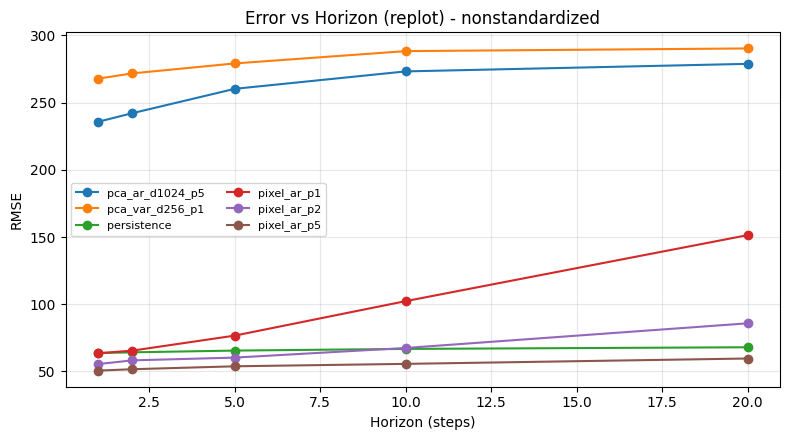

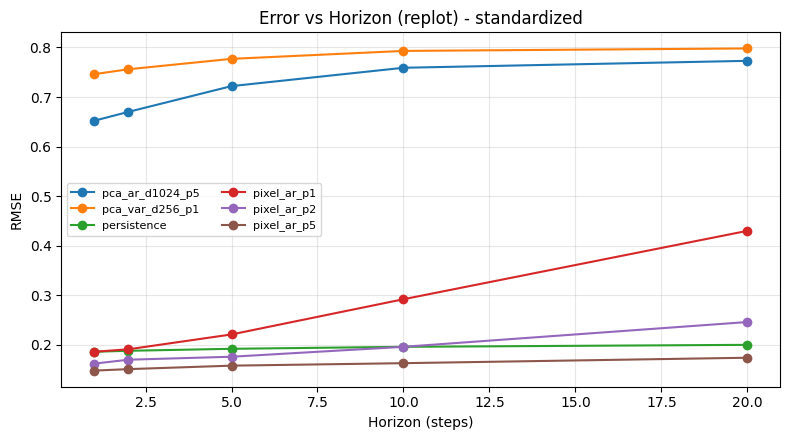

In [ ]:
# Replot Error-vs-Horizon with persistence + all Pixel-AR + best PCA-VAR + best PCA-AR
# Requires: eval_horizons, test_ds_h, horizons, pixel_ar_params, pca_var_params, pca_ar_params

models_replot = {}
models_replot['persistence'] = lambda ctx: predict_persistence(ctx, K=1)

# Include all fitted pixel AR models
for _p in sorted(pixel_ar_params.keys()):
    models_replot[f'pixel_ar_p{_p}'] = (lambda ctx, p=_p: predict_pixel_ar(ctx, pixel_ar_params[p], K=1))

# Include best PCA-VAR by RMSE from metrics table if available; otherwise first available
best_pca_var_name = None
if 'metrics_df' in globals():
    pca_var_rows = metrics_df[metrics_df['model'].astype(str).str.startswith('pca_var_')]
    if len(pca_var_rows) > 0:
        best_pca_var_name = pca_var_rows.sort_values('RMSE_mean', ascending=True).iloc[0]['model']
if best_pca_var_name is None and len(pca_var_params) > 0:
    first_d, first_p = sorted(list(pca_var_params.keys()))[0]
    best_pca_var_name = f'pca_var_d{first_d}_p{first_p}'
if best_pca_var_name is not None:
    parts = str(best_pca_var_name).split('_')
    d = int(parts[2][1:])
    p = int(parts[3][1:])
    models_replot[best_pca_var_name] = (lambda ctx, _d=d, _p=p: predict_pca_var(ctx, pca_var_params[(_d, _p)], K=1))

# Include best PCA-AR by RMSE from metrics table if available; otherwise first available
best_pca_ar_name = None
if 'metrics_df' in globals():
    pca_ar_rows = metrics_df[metrics_df['model'].astype(str).str.startswith('pca_ar_')]
    if len(pca_ar_rows) > 0:
        best_pca_ar_name = pca_ar_rows.sort_values('RMSE_mean', ascending=True).iloc[0]['model']
if best_pca_ar_name is None and len(pca_ar_params) > 0:
    first_d, first_p = sorted(list(pca_ar_params.keys()))[0]
    best_pca_ar_name = f'pca_ar_d{first_d}_p{first_p}'
if best_pca_ar_name is not None:
    parts = str(best_pca_ar_name).split('_')
    d = int(parts[2][1:])
    p = int(parts[3][1:])
    models_replot[best_pca_ar_name] = (lambda ctx, _d=d, _p=p: predict_pca_ar_diag(ctx, pca_ar_params[(_d, _p)], K=1))

# Evaluate horizons for both raw and standardized metrics
horizon_rows_replot = []
horizon_rows_replot_std = []
for name, fn in models_replot.items():
    horizon_rows_replot += [dict(model=name, **r) for r in eval_horizons(fn, test_ds_h, horizons, standardize=False, decimals=3)]
    horizon_rows_replot_std += [dict(model=name, **r) for r in eval_horizons(fn, test_ds_h, horizons, standardize=True, decimals=3)]

horizon_df_replot = pd.DataFrame(horizon_rows_replot).round(3)
horizon_df_replot_std = pd.DataFrame(horizon_rows_replot_std).round(3)

display(horizon_df_replot)
display(horizon_df_replot_std)

# Error-vs-horizon plots only
def plot_error_horizon(df, title_suffix=''):
    plt.figure(figsize=(8, 4.5))
    for model_name, grp in df.groupby('model'):
        grp = grp.sort_values('horizon')
        plt.plot(grp['horizon'], grp['RMSE_mean'], marker='o', label=model_name)
    plt.xlabel('Horizon (steps)')
    plt.ylabel('RMSE')
    plt.title(f'Error vs Horizon {title_suffix}')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=8, ncol=2)
    plt.tight_layout()
    plt.show()

plot_error_horizon(horizon_df_replot, title_suffix=' - nonstandardized')
plot_error_horizon(horizon_df_replot_std, title_suffix=' - standardized')


In [35]:
# Export side-by-side (GT | Pred | Residual) videos for BEST and WORST models by RMSE_mean
import re
import cv2
from pathlib import Path

VIDEO_ACQ_IDX = 0
VIDEO_FPS = 10
VIDEO_PRED_MODE = 'rollout'  # 'teacher_forcing' | 'rollout'
VIDEO_MAX_FRAMES = None
VIDEO_OUT_DIR = Path(repo_root) / 'derivatives' / 'modeling' / 'phase1_baselines' / 'videos'
VIDEO_OUT_DIR.mkdir(parents=True, exist_ok=True)


def build_models_video_registry():
    models_video = {}
    models_video['persistence'] = (lambda ctx: predict_persistence(ctx, K=1))

    if 'pixel_ar_params' in globals() and isinstance(pixel_ar_params, dict):
        for _p in sorted(pixel_ar_params.keys()):
            models_video[f'pixel_ar_p{_p}'] = (lambda ctx, p=_p: predict_pixel_ar(ctx, pixel_ar_params[p], K=1))

    if 'pca_var_params' in globals() and isinstance(pca_var_params, dict):
        for (_d, _p) in sorted(pca_var_params.keys()):
            name = f'pca_var_d{_d}_p{_p}'
            models_video[name] = (lambda ctx, d=_d, p=_p: predict_pca_var(ctx, pca_var_params[(d, p)], K=1))

    if 'pca_ar_params' in globals() and isinstance(pca_ar_params, dict):
        for (_d, _p) in sorted(pca_ar_params.keys()):
            name = f'pca_ar_d{_d}_p{_p}'
            models_video[name] = (lambda ctx, d=_d, p=_p: predict_pca_ar_diag(ctx, pca_ar_params[(d, p)], K=1))

    return models_video


def build_pred_seq(frames, predict_step_fn, W, mode='rollout'):
    frames = np.asarray(frames)
    if frames.ndim != 4 or frames.shape[1] != 1:
        raise ValueError(f'Expected frames shape [T,1,H,W], got {frames.shape}')
    T = frames.shape[0]
    if T <= W:
        raise ValueError(f'Acquisition too short for W={W}: T={T}')

    gt_seq = frames[W:, 0]
    preds = []

    if mode == 'teacher_forcing':
        for t in range(W, T):
            ctx = frames[t-W:t]
            pred = np.asarray(predict_step_fn(ctx))
            preds.append(pred[0, 0])
    elif mode == 'rollout':
        ctx = frames[:W].copy()
        for _ in range(W, T):
            pred = np.asarray(predict_step_fn(ctx))
            preds.append(pred[0, 0])
            ctx = np.concatenate([ctx[1:], pred], axis=0)
    else:
        raise ValueError(f'Unknown mode: {mode}')

    pred_seq = np.stack(preds, axis=0)
    return gt_seq, pred_seq


def _scale_to_uint8(x, lo, hi):
    eps = 1e-8
    x = np.asarray(x, dtype=np.float32)
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
    x = (x - lo) / max(hi - lo, eps)
    x = np.clip(x, 0.0, 1.0)
    return (x * 255.0).astype(np.uint8)


def _robust_abs_scale(x, q=99.5, eps=1e-8):
    vals = np.abs(np.asarray(x, dtype=np.float32))
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        return 1.0
    s = float(np.percentile(vals, float(q)))
    if s < eps:
        s = float(np.max(vals))
    if s < eps:
        s = 1.0
    return s


def save_triplet_video(gt_seq, pred_seq, out_path, fps=10):
    gt_seq = np.asarray(gt_seq, dtype=np.float32)
    pred_seq = np.asarray(pred_seq, dtype=np.float32)

    if gt_seq.shape != pred_seq.shape or gt_seq.ndim != 3:
        raise ValueError(f'gt/pred shapes must match [N,H,W], got {gt_seq.shape} vs {pred_seq.shape}')

    n, h, w = gt_seq.shape
    gt_lo = float(np.min(gt_seq))
    gt_hi = float(np.max(gt_seq))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    writer = cv2.VideoWriter(str(out_path), fourcc, float(fps), (w * 3, h))
    if not writer.isOpened():
        raise RuntimeError(f'Could not open video writer for {out_path}')

    try:
        for i in range(n):
            gt_u8 = _scale_to_uint8(gt_seq[i], gt_lo, gt_hi)
            pr_u8 = _scale_to_uint8(pred_seq[i], gt_lo, gt_hi)
            rs_u8 = cv2.absdiff(pr_u8, gt_u8)

            gt_bgr = cv2.cvtColor(gt_u8, cv2.COLOR_GRAY2BGR)
            pr_bgr = cv2.cvtColor(pr_u8, cv2.COLOR_GRAY2BGR)
            rs_bgr = cv2.cvtColor(rs_u8, cv2.COLOR_GRAY2BGR)

            cv2.putText(gt_bgr, 'GT', (8, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)
            cv2.putText(pr_bgr, 'Pred', (8, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)
            cv2.putText(rs_bgr, 'Residual', (8, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)

            frame = np.concatenate([gt_bgr, pr_bgr, rs_bgr], axis=1)
            writer.write(frame)
    finally:
        writer.release()

def sanitize_name(name):
    return re.sub(r'[^A-Za-z0-9_\-]+', '_', str(name))


if 'metrics_df' not in globals() or len(metrics_df) == 0:
    raise RuntimeError('metrics_df is required and must be non-empty.')

models_video = build_models_video_registry()
if len(models_video) == 0:
    raise RuntimeError('No models available in registry. Run model fitting cells first.')

metrics_sorted = metrics_df.sort_values('RMSE_mean', ascending=True).reset_index(drop=True)
best_name = None
worst_name = None
for n in metrics_sorted['model']:
    n = str(n)
    if n in models_video:
        best_name = n
        break
for n in metrics_sorted['model'][::-1]:
    n = str(n)
    if n in models_video:
        worst_name = n
        break

if best_name is None or worst_name is None:
    raise RuntimeError('Could not map best/worst metrics models to available predictors.')

selected = [best_name] if best_name == worst_name else [best_name, worst_name]

if not (0 <= int(VIDEO_ACQ_IDX) < len(test_ds.acq_paths)):
    raise IndexError(f'VIDEO_ACQ_IDX out of range: {VIDEO_ACQ_IDX} (n_acq={len(test_ds.acq_paths)})')

frames = test_ds._load_acquisition(int(VIDEO_ACQ_IDX))
print(f'Best model: {best_name}')
print(f'Worst model: {worst_name}')
print(f'Selected models ({len(selected)}): {selected}')

for rank_label, model_name in [('best', best_name), ('worst', worst_name)]:
    if model_name not in selected:
        continue

    gt_seq, pred_seq = build_pred_seq(frames, models_video[model_name], W=W, mode=VIDEO_PRED_MODE)
    seq_rmse = float(np.sqrt(np.mean((gt_seq - pred_seq) ** 2)))
    seq_mae = float(np.mean(np.abs(gt_seq - pred_seq)))
    print(f'{rank_label} metrics on exported sequence: RMSE={seq_rmse:.6g}, MAE={seq_mae:.6g}')

    if VIDEO_MAX_FRAMES is not None:
        mmax = int(VIDEO_MAX_FRAMES)
        gt_seq = gt_seq[:mmax]
        pred_seq = pred_seq[:mmax]

    fname = f'{rank_label}__{sanitize_name(model_name)}__acq{int(VIDEO_ACQ_IDX)}__triplet.mp4'
    out_path = VIDEO_OUT_DIR / fname
    if out_path.exists():
        out_path.unlink()

    save_triplet_video(gt_seq, pred_seq, out_path, fps=VIDEO_FPS)
    print(f'Saved {rank_label}: {model_name} -> {out_path} ({len(gt_seq)} frames)')


Best model: pixel_ar_p5
Worst model: pca_var_d1024_p5
Selected models (2): ['pixel_ar_p5', 'pca_var_d1024_p5']
best metrics on exported sequence: RMSE=91.8341, MAE=37.616
Saved best: pixel_ar_p5 -> c:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\modeling\phase1_baselines\videos\best__pixel_ar_p5__acq0__triplet.mp4 (528 frames)
worst metrics on exported sequence: RMSE=inf, MAE=3.06041e+26
Saved worst: pca_var_d1024_p5 -> c:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\modeling\phase1_baselines\videos\worst__pca_var_d1024_p5__acq0__triplet.mp4 (528 frames)


C:\Users\ESPCI\AppData\Local\Temp\ipykernel_17812\2739205795.py:164: RuntimeWarning: overflow encountered in square
  seq_rmse = float(np.sqrt(np.mean((gt_seq - pred_seq) ** 2)))


In [49]:
# Statistical comparison for non-PCA models (persistence + pixel_ar_p*)
from itertools import combinations
from scipy.stats import wilcoxon, ttest_rel

# Build model registry (non-PCA only)
models_non_pca = {'persistence': (lambda ctx: predict_persistence(ctx, K=1))}
if 'pixel_ar_params' in globals() and isinstance(pixel_ar_params, dict):
    for _p in sorted(pixel_ar_params.keys()):
        models_non_pca[f'pixel_ar_p{_p}'] = (lambda ctx, p=_p: predict_pixel_ar(ctx, pixel_ar_params[p], K=1))

if len(models_non_pca) < 2:
    raise RuntimeError('Need at least two non-PCA models (persistence/pixel_ar) to compare.')

# Use metadata-enabled dataset to aggregate by acquisition (more defensible than per-window p-values)
test_ds_stats = FUSForecastWindowDataset(
    manifest_path=manifest_path,
    split='test',
    window_size=W,
    pred_horizon=K,
    stride=S,
    return_meta=True,
)

# Per-window RMSE per model, tagged by acquisition path
rows = []
for i in range(len(test_ds_stats)):
    context, target, meta = test_ds_stats[i]
    ctx = context.detach().cpu().numpy() if hasattr(context, 'detach') else np.asarray(context)
    tgt = target.detach().cpu().numpy() if hasattr(target, 'detach') else np.asarray(target)
    gt = tgt[0, 0]

    for model_name, fn in models_non_pca.items():
        pred = np.asarray(fn(ctx))
        pr = pred[0, 0]
        rmse = float(np.sqrt(np.mean((pr - gt) ** 2)))
        rows.append({'path': meta['path'], 'model': model_name, 'rmse': rmse})

rmse_win_df = pd.DataFrame(rows)

# Aggregate to acquisition-level means (reduces dependence vs overlapping windows)
rmse_acq_df = (
    rmse_win_df
    .groupby(['path', 'model'], as_index=False)['rmse']
    .mean()
)

pivot = rmse_acq_df.pivot(index='path', columns='model', values='rmse').dropna(axis=0)
if pivot.shape[0] < 2:
    raise RuntimeError('Not enough acquisitions with complete model coverage for paired tests.')

pair_rows = []
for a, b in combinations(pivot.columns.tolist(), 2):
    x = pivot[a].values
    y = pivot[b].values
    d = y - x  # positive means model b has higher RMSE (worse)

    # Wilcoxon signed-rank (robust paired nonparametric)
    try:
        w_stat, w_p = wilcoxon(x, y, alternative='two-sided', zero_method='wilcox')
    except Exception:
        w_stat, w_p = np.nan, np.nan

    # Paired t-test (reported as supplementary)
    try:
        t_stat, t_p = ttest_rel(x, y, nan_policy='omit')
    except Exception:
        t_stat, t_p = np.nan, np.nan

    pair_rows.append({
        'model_a': a,
        'model_b': b,
        'n_acq': int(len(x)),
        'mean_rmse_a': float(np.mean(x)),
        'mean_rmse_b': float(np.mean(y)),
        'mean_delta_b_minus_a': float(np.mean(d)),
        'median_delta_b_minus_a': float(np.median(d)),
        'wilcoxon_stat': float(w_stat) if np.isfinite(w_stat) else np.nan,
        'wilcoxon_p': float(w_p) if np.isfinite(w_p) else np.nan,
        'ttest_stat': float(t_stat) if np.isfinite(t_stat) else np.nan,
        'ttest_p': float(t_p) if np.isfinite(t_p) else np.nan,
    })

pair_df = pd.DataFrame(pair_rows)

# Multiple-testing correction on Wilcoxon p-values
try:
    from statsmodels.stats.multitest import multipletests
    valid = pair_df['wilcoxon_p'].notna().values
    pvals = pair_df.loc[valid, 'wilcoxon_p'].values
    if len(pvals) > 0:
        _, p_holm, _, _ = multipletests(pvals, method='holm')
        _, p_fdr, _, _ = multipletests(pvals, method='fdr_bh')
        pair_df.loc[valid, 'wilcoxon_p_holm'] = p_holm
        pair_df.loc[valid, 'wilcoxon_p_fdr_bh'] = p_fdr
except Exception:
    pass

pair_df = pair_df.sort_values('wilcoxon_p', na_position='last').reset_index(drop=True)

print(f'Acquisitions used for paired tests: {pivot.shape[0]}')
display(pair_df.round(6))

# Optional: save table
stats_out = Path(output_dir) / 'non_pca_model_stats_acq_level.csv'
pair_df.to_csv(stats_out, index=False)
print(f'Saved: {stats_out}')


Acquisitions used for paired tests: 6


,model_a,model_b,n_acq,mean_rmse_a,mean_rmse_b,mean_delta_b_minus_a,median_delta_b_minus_a,wilcoxon_stat,wilcoxon_p,ttest_stat,ttest_p,wilcoxon_p_holm,wilcoxon_p_fdr_bh
0,persistence,pixel_ar_p2,6,70.396546,61.363032,-9.033514,-8.492966,0.0,0.03125,4.230296,0.008246,0.1875,0.0375
1,persistence,pixel_ar_p5,6,70.396546,56.080579,-14.315967,-13.075378,0.0,0.03125,4.168895,0.008748,0.1875,0.0375
2,pixel_ar_p1,pixel_ar_p2,6,70.332873,61.363032,-8.969840,-8.307816,0.0,0.03125,4.106426,0.009296,0.1875,0.0375
3,pixel_ar_p1,pixel_ar_p5,6,70.332873,56.080579,-14.252293,-12.863943,0.0,0.03125,4.089598,0.009451,0.1875,0.0375
4,pixel_ar_p2,pixel_ar_p5,6,61.363032,56.080579,-5.282453,-4.544243,0.0,0.03125,4.040127,0.009921,0.1875,0.0375
5,persistence,pixel_ar_p1,6,70.396546,70.332873,-0.063674,-0.141613,6.0,0.43750,0.695485,0.517743,0.4375,0.4375


Saved: c:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\modeling\phase1_baselines\non_pca_model_stats_acq_level.csv


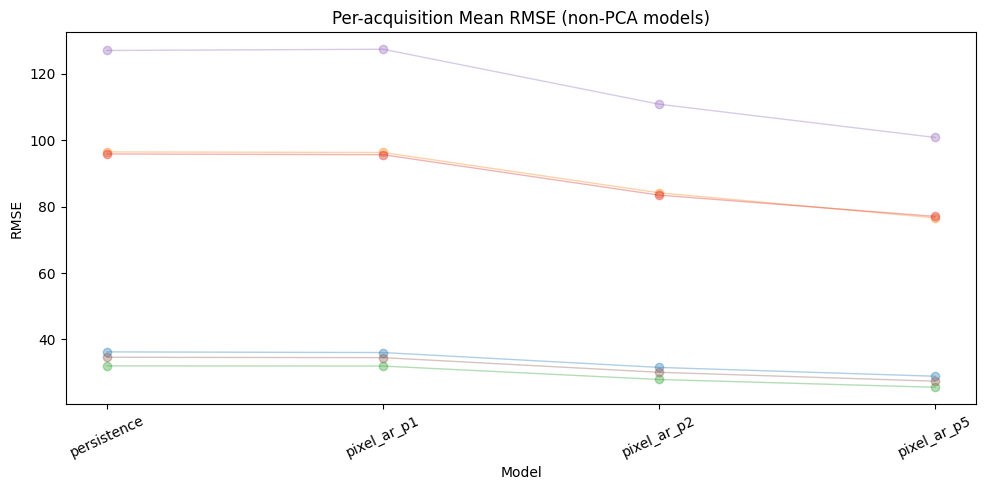

C:\Users\ESPCI\AppData\Local\Temp\ipykernel_17812\2375239154.py:100: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(grouped, labels=sorted(delta_df['model'].unique(), key=_model_sort_key), showfliers=True)


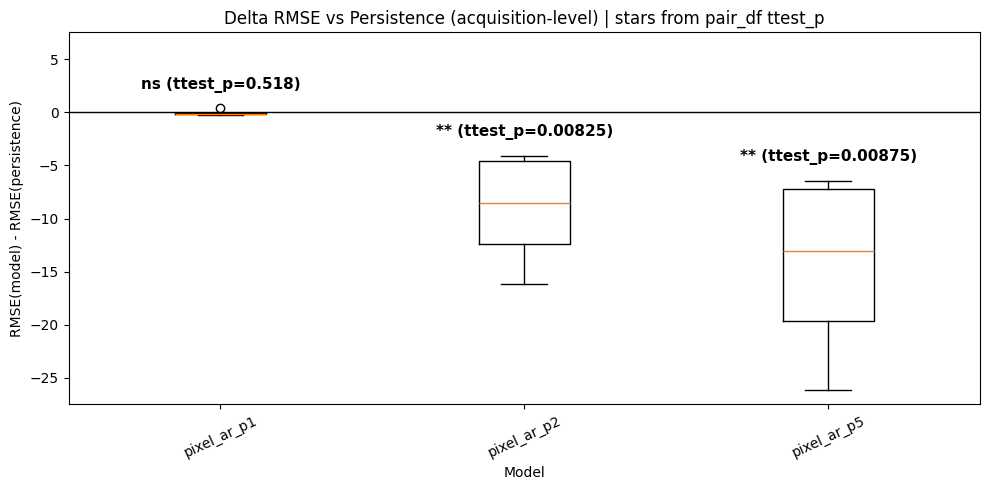

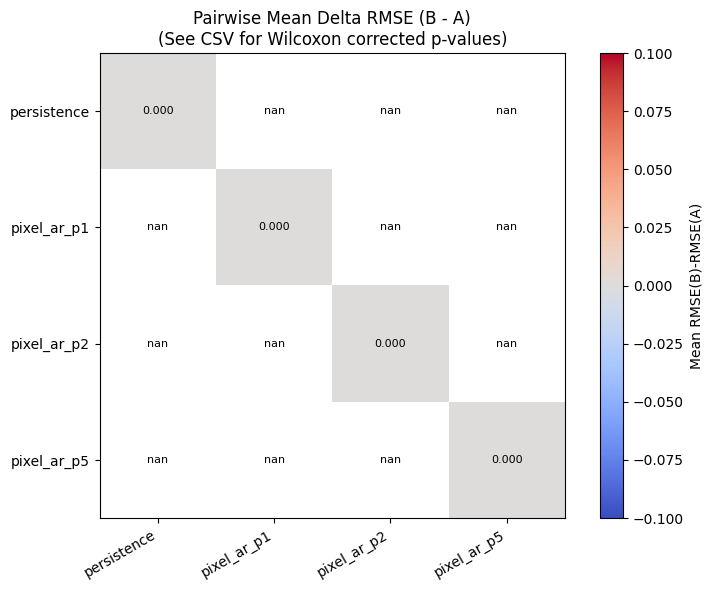

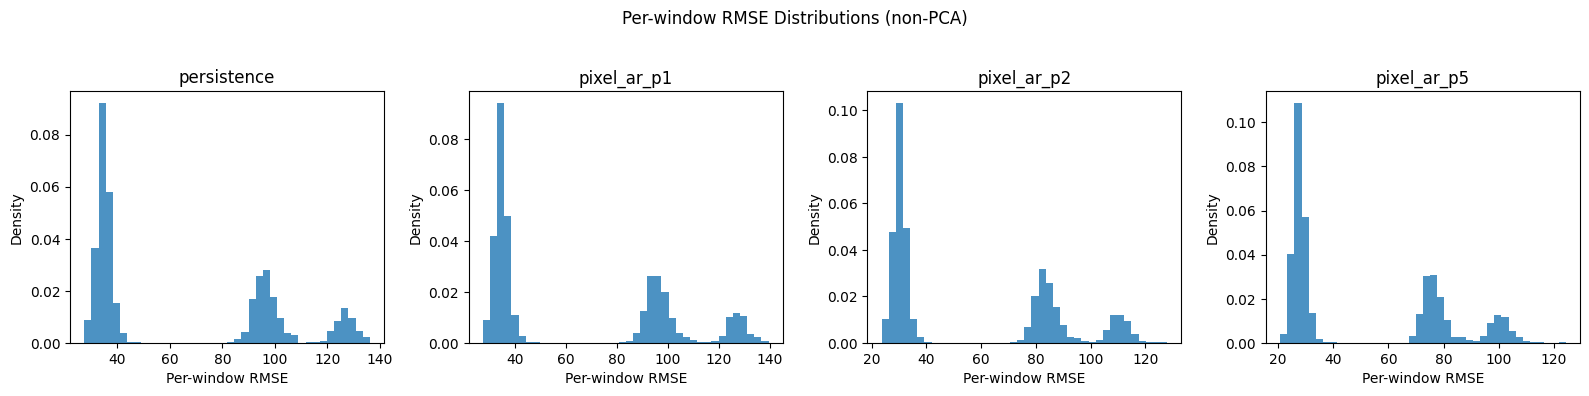

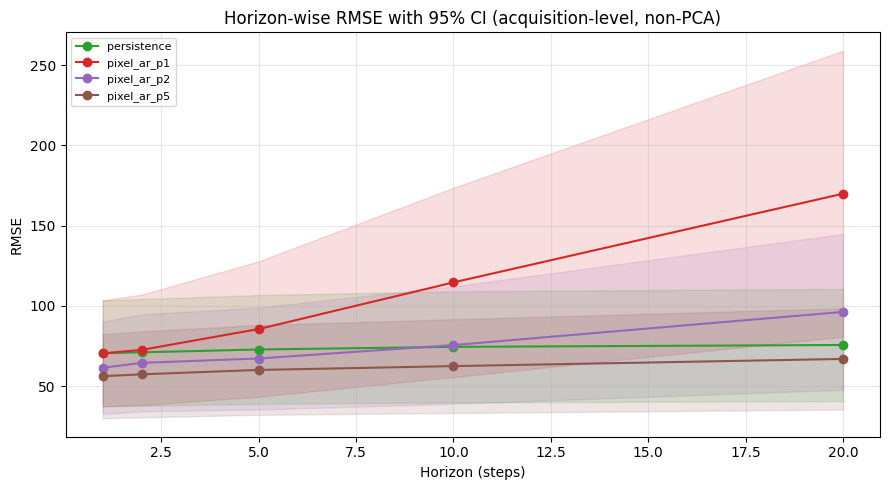

Saved plots to: c:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\modeling\phase1_baselines\stats_plots_non_pca


C:\Users\ESPCI\AppData\Local\Temp\ipykernel_17812\2375239154.py:346: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(grouped, labels=order_h, showfliers=True)
C:\Users\ESPCI\AppData\Local\Temp\ipykernel_17812\2375239154.py:346: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(grouped, labels=order_h, showfliers=True)
C:\Users\ESPCI\AppData\Local\Temp\ipykernel_17812\2375239154.py:346: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(grouped, labels=order_h, showfliers=True)
C:\Users\ESPCI\AppData\Local\Temp\ipykernel_17812\2375239154.py:346: MatplotlibDeprecationWarning: The 'labels' parameter

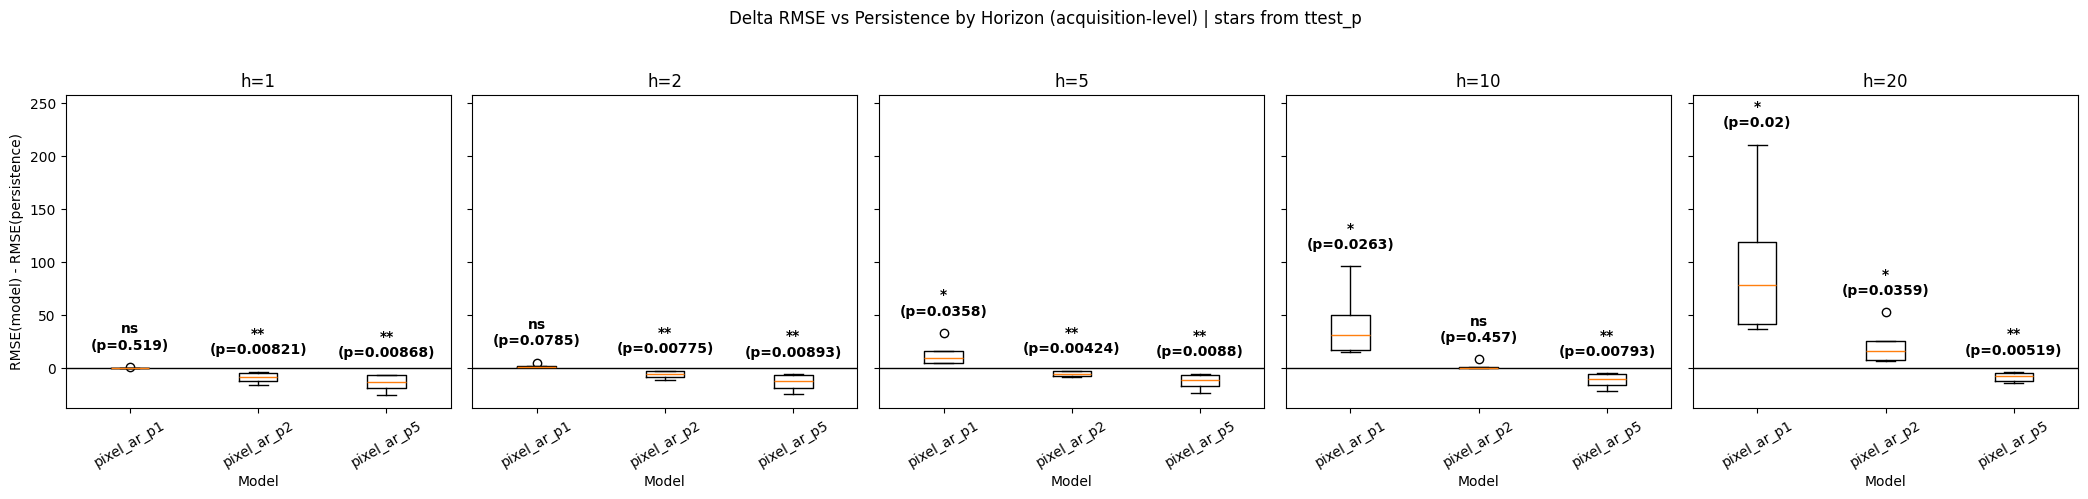

Saved: c:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\modeling\phase1_baselines\stats_plots_non_pca\06_delta_vs_persistence_by_horizon_boxplots.png
Saved: c:\Users\ESPCI\Documents\GitHub\fUSPredict\derivatives\modeling\phase1_baselines\stats_plots_non_pca\06_delta_vs_persistence_by_horizon_ttest.csv


In [52]:
# Plots for non-PCA statistical comparison
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import wilcoxon, ttest_rel
from statsmodels.stats.multitest import multipletests

# Optional prettier plots if seaborn is available
try:
    import seaborn as sns
    sns.set_context('talk')
    sns.set_style('whitegrid')
    _HAS_SNS = True
except Exception:
    _HAS_SNS = False

if 'pivot' not in globals() or 'pair_df' not in globals() or 'rmse_win_df' not in globals():
    raise RuntimeError('Run the non-PCA stats cell first (needs pivot, pair_df, rmse_win_df).')

# Model order: persistence first, then pixel_ar by p
def _model_sort_key(name):
    n = str(name)
    if n == 'persistence':
        return (0, 0)
    if n.startswith('pixel_ar_p'):
        try:
            return (1, int(n.split('p')[-1]))
        except Exception:
            return (1, 999)
    return (2, 999)

model_order = sorted(list(pivot.columns), key=_model_sort_key)
plot_dir = Path(output_dir) / 'stats_plots_non_pca'
plot_dir.mkdir(parents=True, exist_ok=True)

# 1) Per-acquisition RMSE slope plot (paired lines)
fig, ax = plt.subplots(figsize=(10, 5))
for acq in pivot.index:
    ax.plot(model_order, pivot.loc[acq, model_order].values, marker='o', alpha=0.35, linewidth=1)
ax.set_title('Per-acquisition Mean RMSE (non-PCA models)')
ax.set_xlabel('Model')
ax.set_ylabel('RMSE')
ax.tick_params(axis='x', rotation=25)
fig.tight_layout()
fig.savefig(plot_dir / '01_acquisition_slope_rmse.png', dpi=300)
plt.show()

# 2) Delta RMSE vs persistence (box/violin + jitter)
if 'persistence' in model_order:
    delta_rows = []
    for m in model_order:
        if m == 'persistence':
            continue
        d = pivot[m] - pivot['persistence']
        for acq, val in d.items():
            delta_rows.append({'path': acq, 'model': m, 'delta_rmse_vs_persistence': float(val)})
    delta_df = pd.DataFrame(delta_rows)

    # Significance labels aligned with pair_df, using paired t-test p-values only
    delta_models = sorted(delta_df['model'].unique(), key=_model_sort_key)
    if 'pair_df' not in globals():
        raise RuntimeError('pair_df not found. Run the non-PCA stats cell first.')

    sig_rows = []
    for m in delta_models:
        rows_pm = pair_df[(pair_df['model_a'] == 'persistence') & (pair_df['model_b'] == m)]
        if len(rows_pm) == 0:
            rows_pm = pair_df[(pair_df['model_b'] == 'persistence') & (pair_df['model_a'] == m)]
        if len(rows_pm) == 0:
            sig_rows.append({'model': m, 'n': np.nan, 'ttest_p': np.nan})
            continue
        r = rows_pm.iloc[0]
        sig_rows.append({
            'model': m,
            'n': int(r['n_acq']) if pd.notna(r['n_acq']) else np.nan,
            'ttest_p': float(r['ttest_p']) if pd.notna(r['ttest_p']) else np.nan,
        })
    sig_df = pd.DataFrame(sig_rows)

    def _p_to_stars(p):
        if not np.isfinite(p):
            return 'ns'
        if p < 1e-3:
            return '***'
        if p < 1e-2:
            return '**'
        if p < 5e-2:
            return '*'
        return 'ns'

    fig, ax = plt.subplots(figsize=(10, 5))
    if _HAS_SNS:
        sns.violinplot(data=delta_df, x='model', y='delta_rmse_vs_persistence', inner=None, cut=0, ax=ax, color='#b3cde3')
        sns.boxplot(data=delta_df, x='model', y='delta_rmse_vs_persistence', width=0.25, showcaps=True, boxprops={'facecolor':'white'}, ax=ax)
        sns.stripplot(data=delta_df, x='model', y='delta_rmse_vs_persistence', size=4, alpha=0.6, color='black', ax=ax)
    else:
        grouped = [delta_df[delta_df['model'] == m]['delta_rmse_vs_persistence'].values for m in sorted(delta_df['model'].unique(), key=_model_sort_key)]
        ax.boxplot(grouped, labels=sorted(delta_df['model'].unique(), key=_model_sort_key), showfliers=True)
    ax.axhline(0.0, color='k', linewidth=1)
    ax.set_title('Delta RMSE vs Persistence (acquisition-level) | stars from pair_df ttest_p')
    ax.set_xlabel('Model')
    ax.set_ylabel('RMSE(model) - RMSE(persistence)')
    ax.tick_params(axis='x', rotation=25)

    # Add significance stars using categorical tick positions
    y_min, y_max = ax.get_ylim()
    y_span = y_max - y_min
    tick_labels = [t.get_text() for t in ax.get_xticklabels()]
    tick_pos = ax.get_xticks()
    x_map = {lab: float(pos) for lab, pos in zip(tick_labels, tick_pos)}
    for m in delta_models:
        if m not in x_map:
            continue
        vals = delta_df.loc[delta_df['model'] == m, 'delta_rmse_vs_persistence'].values.astype(float)
        vals = vals[np.isfinite(vals)]
        if len(vals) == 0:
            continue
        y = float(np.max(vals)) + 0.05 * y_span
        rr = sig_df.loc[sig_df['model'] == m]
        if len(rr) == 0:
            continue
        p_ttest = float(rr.iloc[0]['ttest_p']) if pd.notna(rr.iloc[0]['ttest_p']) else np.nan
        stars = _p_to_stars(p_ttest)
        label = stars if not np.isfinite(p_ttest) else f'{stars} (ttest_p={p_ttest:.3g})'
        ax.text(x_map[m], y, label, ha='center', va='bottom', fontsize=11, fontweight='bold', clip_on=False)
    ax.set_ylim(y_min, y_max + 0.20 * y_span)

    fig.tight_layout()
    fig.savefig(plot_dir / '02_delta_vs_persistence_violin_box.png', dpi=300)
    sig_df.to_csv(plot_dir / '02_delta_vs_persistence_significance.csv', index=False)
    plt.show()
# 3) Pairwise delta heatmap with corrected p-values
models = model_order
delta_mat = pd.DataFrame(np.nan, index=models, columns=models)
p_mat = pd.DataFrame(np.nan, index=models, columns=models)

for i, a in enumerate(models):
    for j, b in enumerate(models):
        if a == b:
            delta_mat.loc[a, b] = 0.0
            p_mat.loc[a, b] = np.nan
            if a in pivot.columns and b in pivot.columns:
                delta_mat.loc[a, b] = float(np.mean(pivot[b] - pivot[a]))

for _, r in pair_df.iterrows():
    a = str(r['model_a'])
    b = str(r['model_b'])
    if a in p_mat.index and b in p_mat.columns:
        pval = r['wilcoxon_p_holm'] if 'wilcoxon_p_holm' in pair_df.columns and pd.notna(r.get('wilcoxon_p_holm', np.nan)) else r['wilcoxon_p']
        p_mat.loc[a, b] = pval
        p_mat.loc[b, a] = pval

fig, ax = plt.subplots(figsize=(8, 6))
if _HAS_SNS:
    sns.heatmap(delta_mat.astype(float), annot=True, fmt='.3f', cmap='coolwarm', center=0.0, cbar_kws={'label': 'Mean RMSE(B)-RMSE(A)'}, ax=ax)
else:
    im = ax.imshow(delta_mat.astype(float).values, cmap='coolwarm')
    fig.colorbar(im, ax=ax, label='Mean RMSE(B)-RMSE(A)')
    ax.set_xticks(range(len(models))); ax.set_xticklabels(models, rotation=30, ha='right')
    ax.set_yticks(range(len(models))); ax.set_yticklabels(models)
    for ii in range(len(models)):
        for jj in range(len(models)):
            ax.text(jj, ii, f"{delta_mat.iloc[ii, jj]:.3f}", ha='center', va='center', fontsize=8)

ax.set_title('Pairwise Mean Delta RMSE (B - A)\n(See CSV for Wilcoxon corrected p-values)')
fig.tight_layout()
fig.savefig(plot_dir / '03_pairwise_delta_heatmap.png', dpi=300)
plt.show()

# Save p-value matrix for reference
p_mat.to_csv(plot_dir / '03_pairwise_pvalues_matrix.csv')

# 4) Per-window error distributions by model
fig, axes = plt.subplots(1, len(model_order), figsize=(4 * len(model_order), 3.8), sharex=False, sharey=False)
if len(model_order) == 1:
    axes = [axes]
for ax, m in zip(axes, model_order):
    vals = rmse_win_df.loc[rmse_win_df['model'] == m, 'rmse'].values
    if _HAS_SNS:
        sns.histplot(vals, bins=40, kde=True, stat='density', ax=ax, color='#4c78a8')
    else:
        ax.hist(vals, bins=40, density=True, alpha=0.8)
    ax.set_title(m)
    ax.set_xlabel('Per-window RMSE')
    ax.set_ylabel('Density')
fig.suptitle('Per-window RMSE Distributions (non-PCA)', y=1.03)
fig.tight_layout()
fig.savefig(plot_dir / '04_per_window_rmse_distributions.png', dpi=300)
plt.show()

# 5) Horizon-wise RMSE with 95% CI (acquisition-level aggregation)
horizons_plot = [1, 2, 5, 10, 20]
max_h_plot = max(horizons_plot)

test_ds_h_stats = FUSForecastWindowDataset(
    manifest_path=manifest_path,
    split='test',
    window_size=W,
    pred_horizon=max_h_plot,
    stride=S,
    return_meta=True,
)

# predictor registry (non-PCA only)
predictors_np = {'persistence': (lambda ctx: predict_persistence(ctx, K=1))}
if 'pixel_ar_params' in globals() and isinstance(pixel_ar_params, dict):
    for _p in sorted(pixel_ar_params.keys()):
        predictors_np[f'pixel_ar_p{_p}'] = (lambda ctx, p=_p: predict_pixel_ar(ctx, pixel_ar_params[p], K=1))
predictors_np = {k: predictors_np[k] for k in model_order if k in predictors_np}


def _to_np(x):
    if hasattr(x, 'detach'):
        x = x.detach().cpu().numpy()
    return np.asarray(x)


def _rollout_predict(step_fn, context, K):
    ctx = _to_np(context)
    preds = []
    for _ in range(int(K)):
        step = np.asarray(step_fn(ctx))  # [1,1,H,W]
        preds.append(step[0])
        ctx = np.concatenate([ctx[1:], step], axis=0)
    return np.stack(preds, axis=0)

h_rows = []
for i in range(len(test_ds_h_stats)):
    context, target, meta = test_ds_h_stats[i]
    tgt = _to_np(target)
    for m, fn in predictors_np.items():
        pred = _rollout_predict(fn, context, max_h_plot)
        for h in horizons_plot:
            gt = tgt[h - 1, 0]
            pr = pred[h - 1, 0]
            rmse_h = float(np.sqrt(np.mean((pr - gt) ** 2)))
            h_rows.append({'path': meta['path'], 'model': m, 'horizon': int(h), 'rmse': rmse_h})

h_df = pd.DataFrame(h_rows)
h_acq = h_df.groupby(['path', 'model', 'horizon'], as_index=False)['rmse'].mean()
h_stats = h_acq.groupby(['model', 'horizon']).agg(
    rmse_mean=('rmse', 'mean'),
    rmse_std=('rmse', 'std'),
    n_acq=('rmse', 'count')
).reset_index()
h_stats['rmse_sem'] = h_stats['rmse_std'] / np.sqrt(h_stats['n_acq'].clip(lower=1))
h_stats['ci95'] = 1.96 * h_stats['rmse_sem']

fig, ax = plt.subplots(figsize=(9, 5))
model_colors_non_pca = {
    'persistence': 'tab:green',
    'pixel_ar_p1': 'tab:red',
    'pixel_ar_p2': 'tab:purple',
    'pixel_ar_p5': 'tab:brown',
}
for m in model_order:
    g = h_stats[h_stats['model'] == m].sort_values('horizon')
    if len(g) == 0:
        continue
    x = g['horizon'].values
    y = g['rmse_mean'].values
    c = g['ci95'].fillna(0.0).values
    color_m = model_colors_non_pca.get(m, None)
    ax.plot(x, y, marker='o', label=m, color=color_m)
    ax.fill_between(x, y - c, y + c, alpha=0.15, color=color_m)
ax.set_title('Horizon-wise RMSE with 95% CI (acquisition-level, non-PCA)')
ax.set_xlabel('Horizon (steps)')
ax.set_ylabel('RMSE')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=8)
fig.tight_layout()
fig.savefig(plot_dir / '05_horizon_rmse_ci95.png', dpi=300)
plt.show()

# Save plot tables
h_stats.to_csv(plot_dir / '05_horizon_rmse_ci95_table.csv', index=False)
print(f'Saved plots to: {plot_dir}')

# 6) Horizon-specific delta boxplots vs persistence (5 panels) with ttest_p stars
BOOT_N = 5000
BOOT_ALPHA = 0.05
APPLY_MULTITEST_CORR = True  # set False to keep only raw p-values

def _bootstrap_ci(x, stat_fn=np.mean, n_boot=5000, alpha=0.05, seed=42):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if len(x) == 0:
        return (np.nan, np.nan)
    if len(x) == 1:
        s = float(stat_fn(x))
        return (s, s)
    rng = np.random.default_rng(int(seed))
    n = len(x)
    stats = np.empty(int(n_boot), dtype=float)
    for b in range(int(n_boot)):
        idx = rng.integers(0, n, size=n)
        stats[b] = float(stat_fn(x[idx]))
    lo = float(np.percentile(stats, 100.0 * (alpha / 2.0)))
    hi = float(np.percentile(stats, 100.0 * (1.0 - alpha / 2.0)))
    return (lo, hi)

pixel_models = [m for m in model_order if m.startswith('pixel_ar_')]
if 'persistence' in model_order and len(pixel_models) > 0:
    h_delta_rows = []
    h_sig_rows = []

    for h in horizons_plot:
        ph = h_acq[h_acq['horizon'] == h].pivot(index='path', columns='model', values='rmse').dropna(axis=0)
        if 'persistence' not in ph.columns:
            continue

        for m in pixel_models:
            if m not in ph.columns:
                continue
            d = (ph[m] - ph['persistence']).values.astype(float)
            d = d[np.isfinite(d)]
            for val in d:
                h_delta_rows.append({'horizon': int(h), 'model': m, 'delta_rmse_vs_persistence': float(val)})

            if len(d) >= 2:
                try:
                    # one-sample paired equivalent: t-test on deltas vs 0
                    t_stat, p_t = ttest_rel(d, np.zeros_like(d), nan_policy='omit')
                except Exception:
                    t_stat, p_t = np.nan, np.nan
            else:
                t_stat, p_t = np.nan, np.nan
            mean_delta = float(np.mean(d)) if len(d) else np.nan
            median_delta = float(np.median(d)) if len(d) else np.nan
            sd_delta = float(np.std(d, ddof=1)) if len(d) > 1 else np.nan
            cohens_dz = (mean_delta / sd_delta) if (len(d) > 1 and np.isfinite(sd_delta) and sd_delta > 1e-12) else np.nan
            ci_mean_lo, ci_mean_hi = _bootstrap_ci(d, stat_fn=np.mean, n_boot=BOOT_N, alpha=BOOT_ALPHA, seed=42 + int(h))
            ci_med_lo, ci_med_hi = _bootstrap_ci(d, stat_fn=np.median, n_boot=BOOT_N, alpha=BOOT_ALPHA, seed=77 + int(h))
            h_sig_rows.append({
                'horizon': int(h),
                'model': m,
                'n_acq': int(len(d)),
                'mean_delta': mean_delta,
                'median_delta': median_delta,
                'cohens_dz': float(cohens_dz) if np.isfinite(cohens_dz) else np.nan,
                'ci_mean_lo': ci_mean_lo,
                'ci_mean_hi': ci_mean_hi,
                'ci_median_lo': ci_med_lo,
                'ci_median_hi': ci_med_hi,
                'ttest_p': float(p_t) if np.isfinite(p_t) else np.nan,
            })

    h_delta_df = pd.DataFrame(h_delta_rows)
    h_sig_df = pd.DataFrame(h_sig_rows)
    if APPLY_MULTITEST_CORR and len(h_sig_df) > 0:
        valid = h_sig_df['ttest_p'].notna().values
        if valid.any():
            pvals = h_sig_df.loc[valid, 'ttest_p'].values
            _, p_holm, _, _ = multipletests(pvals, method='holm')
            _, p_fdr, _, _ = multipletests(pvals, method='fdr_bh')
            h_sig_df.loc[valid, 'ttest_p_holm'] = p_holm
            h_sig_df.loc[valid, 'ttest_p_fdr_bh'] = p_fdr

    if len(h_delta_df) > 0:
        fig, axes = plt.subplots(1, len(horizons_plot), figsize=(4.2 * len(horizons_plot), 4.8), sharey=True)
        if len(horizons_plot) == 1:
            axes = [axes]

        y_min = float(h_delta_df['delta_rmse_vs_persistence'].min())
        y_max = float(h_delta_df['delta_rmse_vs_persistence'].max())
        y_span = max(1e-6, y_max - y_min)

        def _p_to_stars_t(p):
            if not np.isfinite(p):
                return 'ns'
            if p < 1e-3:
                return '***'
            if p < 1e-2:
                return '**'
            if p < 5e-2:
                return '*'
            return 'ns'

        for ax, h in zip(axes, horizons_plot):
            dsub = h_delta_df[h_delta_df['horizon'] == h]
            if len(dsub) == 0:
                ax.set_title(f'h={h}')
                ax.axis('off')
                continue

            order_h = [m for m in pixel_models if m in dsub['model'].unique()]
            if _HAS_SNS:
                sns.boxplot(data=dsub, x='model', y='delta_rmse_vs_persistence', order=order_h, ax=ax, color='white', width=0.5, showcaps=True)
                sns.stripplot(data=dsub, x='model', y='delta_rmse_vs_persistence', order=order_h, ax=ax, color='black', alpha=0.55, size=3.5)
            else:
                grouped = [dsub[dsub['model'] == m]['delta_rmse_vs_persistence'].values for m in order_h]
                ax.boxplot(grouped, labels=order_h, showfliers=True)

            ax.axhline(0.0, color='k', linewidth=1)
            ax.set_title(f'h={h}')
            ax.set_xlabel('Model')
            ax.tick_params(axis='x', rotation=30)

            # stars
            tick_labels = [t.get_text() for t in ax.get_xticklabels()]
            tick_pos = ax.get_xticks()
            x_map = {lab: float(pos) for lab, pos in zip(tick_labels, tick_pos)}
            for m in order_h:
                vals = dsub[dsub['model'] == m]['delta_rmse_vs_persistence'].values.astype(float)
                vals = vals[np.isfinite(vals)]
                if len(vals) == 0 or m not in x_map:
                    continue
                y_text = float(np.max(vals)) + 0.06 * y_span
                r = h_sig_df[(h_sig_df['horizon'] == h) & (h_sig_df['model'] == m)]
                p_t = float(r.iloc[0]['ttest_p']) if len(r) and pd.notna(r.iloc[0]['ttest_p']) else np.nan
                stars = _p_to_stars_t(p_t)
                lbl = stars if not np.isfinite(p_t) else f'{stars}\n(p={p_t:.3g})'
                ax.text(x_map[m], y_text, lbl, ha='center', va='bottom', fontsize=10, fontweight='bold', clip_on=False)

            ax.set_ylim(y_min - 0.05 * y_span, y_max + 0.20 * y_span)

        axes[0].set_ylabel('RMSE(model) - RMSE(persistence)')
        fig.suptitle('Delta RMSE vs Persistence by Horizon (acquisition-level) | stars from ttest_p', y=1.03)
        fig.tight_layout()
        fig.savefig(plot_dir / '06_delta_vs_persistence_by_horizon_boxplots.png', dpi=300)
        plt.show()

        h_sig_df.to_csv(plot_dir / '06_delta_vs_persistence_by_horizon_ttest.csv', index=False)
        h_sig_df.to_csv(plot_dir / '06_delta_vs_persistence_by_horizon_effects.csv', index=False)
        display_cols = ['horizon','model','n_acq','mean_delta','ci_mean_lo','ci_mean_hi','median_delta','ci_median_lo','ci_median_hi','cohens_dz','ttest_p']
        if 'ttest_p_holm' in h_sig_df.columns:
            display_cols.append('ttest_p_holm')
        if 'ttest_p_fdr_bh' in h_sig_df.columns:
            display_cols.append('ttest_p_fdr_bh')
        display(h_sig_df[display_cols].sort_values(['horizon','model']).round(6))

        print('Saved:', plot_dir / '06_delta_vs_persistence_by_horizon_boxplots.png')
        print('Saved:', plot_dir / '06_delta_vs_persistence_by_horizon_ttest.csv')
        print('Saved:', plot_dir / '06_delta_vs_persistence_by_horizon_effects.csv')
